# COVID-19 Anxiety Monitor
Aim:
- Scrape London-based Tweets related to #Coronavirus
- Apply Vader to run Sentiment Analysis
- Chart Sentiment over the period: How have Londoners' attitudes changed as the virus progressed?

## Import packages

In [22]:
import GetOldTweets3 as got
import twitter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
from sklearn.feature_extraction import DictVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Load Existing Twitter Data

In [58]:
'''Reload tweets csv. Good practise to check/correct dtypes at this stage'''
tweets = pd.read_csv('./data/tweets.csv', parse_dates=['date'])

## Retrieve Tweets
- Twitter Official API has time constraints, you can't get older tweets than a week. 
- Some tools provide access to older tweets but in the most of them you have to spend some money before.
- GetOldTweets3 mimics a Twitter search so we can search older tweets: when you enter on Twitter page a scroll loader starts, if you scroll down you start to get more and more tweets, all through calls to a JSON provider.

In [7]:
def getoldtweets(since, until, query='#Coronavirus', near='London, UK', maxtweets=10000):
    '''
    Wrap TweetCriteria class in a function to enable dynamic setting of variables when called
    '''
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('{}'.format(query))\
                                           .setSince('{}'.format(since))\
                                           .setUntil('{}'.format(until))\
                                           .setNear('{}'.format(near))\
                                           .setMaxTweets(maxtweets)

    tweets = got.manager.TweetManager.getTweets(tweetCriteria)
    return tweets

In [50]:
'''
Collate tweets per day into a tweets_dict
'''
tweets_dict = {}
start = '2020-03-24'
datelist = pd.date_range(start, end=datetime.today()-timedelta(days=1)).tolist()
    
for date in datelist:
    tweets_dict[str(date)[:10]] = getoldtweets(str(date)[:10], str(date+timedelta(days=1))[:10])
    
tweets = []
for tweetquery in list(tweets_dict.values()):
    for tweet in tweetquery:
        tweets.append(tweet)

print('Total No. Tweets retrieved: {}'.format(len(tweets)))
print('For Date Range: {} - {}'.format(start,datetime.today()-timedelta(days=1)))

/Users/Noah/anaconda3/envs/nlp_architect/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


Total No. Tweets retrieved:  31257


In [66]:
'''Appending new tweets to existing data'''

tweets_df = []

for tweetquery in list(tweets_dict.values()):
    for tweet in tweetquery:
        '''
        Retrieve all tweets from tweets_dict and create a dataframe of attributes
        '''
        tweets_df.append([tweet.username, tweet.id, tweet.date, tweet.favorites, tweet.hashtags,
                          tweet.mentions, tweet.retweets, tweet.replies, tweet.text])

tweets_df = pd.DataFrame(tweets_df,columns=['username','tweet_id','date','favorites','hashtags',
                                            'mentions','retweets','replies','text'])

tweets = pd.concat([tweets,tweets_df])
tweets = tweets.drop_duplicates(ignore_index=True)

tweets.to_csv('./data/tweets.csv', index=False)

## Sentiment Analysis

VaderSentiment metrics explained:
- Pos: Proportion of the text that falls into the positive category: ie. no.pos words / total no.words
- Neu: Proportion of the text that falls into the neutral category: ie. no.neu words / total no.words
- Neg: Proportion of the text that falls into the negative category: ie. no.neg words / total no.words

... so these 3 metrics should up to 1 for a given text

- Compound: Summing the valence scores of each word in the text, and normalized to between -1 (neg) and 1 (pos). 
  - This gives us a polarity measure for that text.
  - It's normalized so can be used to compare different texts
  - Note - researchers usually use +/-0.05 as the threshold for becoming pos/neg

In [67]:
analyzer = SentimentIntensityAnalyzer()
'''
SentimentIntensityAnalyzer will calculate the 4 vader sentiment measures for each
We use it's polarity_scores method to map tweets to their vader_scores:
'''
vader_scores = tweets['text'].map(analyzer.polarity_scores)
vader_scores.head(2)

0    {'neg': 0.069, 'neu': 0.882, 'pos': 0.049, 'co...
1    {'neg': 0.271, 'neu': 0.729, 'pos': 0.0, 'comp...
Name: text, dtype: object

In [68]:
dvec = DictVectorizer() 
'''
DictVectorizer takes the list of dictionaries created by analyzer, and vectorize it.
Such that the keys will become the columns in a sparse matrix once fit_transform applied:
'''
vader_scores = dvec.fit_transform(vader_scores)
dvec.feature_names_

['compound', 'neg', 'neu', 'pos']

In [69]:
'''Now we can add the scores to the tweets dataframe:'''
tweets = pd.concat([tweets,pd.DataFrame(vader_scores.toarray(),columns=dvec.feature_names_)],axis=1)

## Visualising scores by date

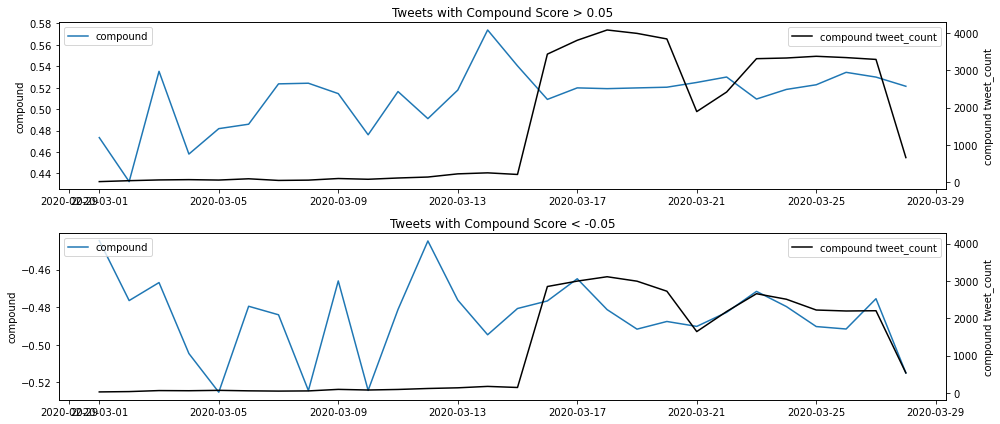

In [70]:
'''Group Sentiment by Date and plot'''

score = 'compound' # Choose sentiment metric
pos_threshold = 0.05 # Choose threshold for positive valence
neg_threshold = -0.05 # Choose threshold for negative valence

tweets_pos_valence = tweets[(tweets['{}'.format(score)]>pos_threshold)]
tweets_neg_valence = tweets[(tweets['{}'.format(score)]<neg_threshold)]

fig, ax = plt.subplots(figsize=(14,6))

# adds subplots to current figure and assigns them to variables
ax0 = plt.subplot(211)
ax1 = ax0.twinx()
ax2 = plt.subplot(212)
ax3 = ax2.twinx()

# share y-axes to have both plots to same scale:
ax1.get_shared_y_axes().join(ax1, ax3)

# Plot data on their respective axes:
ax0.plot(tweets_pos_valence.groupby(tweets_pos_valence.date.dt.date)['{}'.format(score)].mean(),
           label='{}'.format(score))
ax0.set_ylabel('{}'.format(score))
ax0.legend(loc='upper left');
ax0.set_title('Tweets with Compound Score > {}'.format(pos_threshold))

ax1.plot(tweets_pos_valence.groupby(tweets_pos_valence.date.dt.date)['{}'.format(score)].count(),
          label='{} tweet_count'.format(score), c='k')
ax1.set_ylabel('{} tweet_count'.format(score))
ax1.legend(loc='upper right');

ax2.plot(tweets_neg_valence.groupby(tweets_neg_valence.date.dt.date)['{}'.format(score)].mean(),
           label='{}'.format(score))
ax2.set_ylabel('{}'.format(score))
ax2.legend(loc='upper left');
ax2.set_title('Tweets with Compound Score < {}'.format(neg_threshold))

ax3.plot(tweets_neg_valence.groupby(tweets_neg_valence.date.dt.date)['{}'.format(score)].count(),
          label='{} tweet_count'.format(score), c='k')
ax3.set_ylabel('{} tweet_count'.format(score))
ax3.legend(loc='upper right');

plt.tight_layout();

In [82]:
# THEN... supplement with spread of no. cases / deaths data. Can you see any relationships worth modelling?
# Look at the papers saved... can you predict the epidemic spread based on sentiment?